In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, imaging_type_encoder=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:  # Use same flag as label encoder for consistency
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Get the fitted imaging type encoder
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
class MViTWithImagingType(nn.Module):
    """Wrapper class that adds imaging type embedding to MViT"""
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(MViTWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Replace the final head with identity to get features
        self.base_model.head.drop = nn.Identity()
        self.base_model.head.fc = nn.Identity()
        
        # Create embedding for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes image features + imaging type embedding
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features from base model
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_mvit_model(architecture='mvitv2_tiny', num_classes=4, num_imaging_types=2, pretrained=True):
    """Create MViT v2 (Multiscale Vision Transformer) model with imaging type support for multi-class classification"""
    if architecture == 'mvitv2_tiny':
        base_model = timm.create_model('mvitv2_tiny', pretrained=pretrained, num_classes=0)
    elif architecture == 'mvitv2_small':
        base_model = timm.create_model('mvitv2_small', pretrained=pretrained, num_classes=0)
    elif architecture == 'mvitv2_base':
        base_model = timm.create_model('mvitv2_base', pretrained=pretrained, num_classes=0)
    else:
        raise ValueError("Architecture must be 'mvitv2_tiny', 'mvitv2_small', or 'mvitv2_base'")
    
    # Get number of features from the model
    num_features = base_model.num_features
    
    # Wrap model with imaging type support
    model = MViTWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train MViT v2 Tiny

Training MViT v2 Tiny with Imaging Type


model.safetensors:   0%|          | 0.00/96.7M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:15<00:00,  2.48it/s, Loss=1.4091, Acc=0.2590]


Train Loss: 1.4091 Acc: 0.2590 Macro-F1: 0.2468


Val : 100%|██████████| 10/10 [00:01<00:00,  5.29it/s, Loss=1.4223, Acc=0.3289]


Val Loss: 1.4223 Acc: 0.3289 Macro-F1: 0.1849
✓ New best model saved with validation macro-F1: 0.1849

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.3962, Acc=0.2656]


Train Loss: 1.3962 Acc: 0.2656 Macro-F1: 0.2485


Val : 100%|██████████| 10/10 [00:01<00:00,  6.51it/s, Loss=1.3573, Acc=0.2763]


Val Loss: 1.3573 Acc: 0.2763 Macro-F1: 0.1082

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.73it/s, Loss=1.3891, Acc=0.2854]


Train Loss: 1.3891 Acc: 0.2854 Macro-F1: 0.2368


Val : 100%|██████████| 10/10 [00:01<00:00,  6.55it/s, Loss=1.3188, Acc=0.3289]


Val Loss: 1.3188 Acc: 0.3289 Macro-F1: 0.1984
✓ New best model saved with validation macro-F1: 0.1984

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.3168, Acc=0.4424]


Train Loss: 1.3168 Acc: 0.4424 Macro-F1: 0.3670


Val : 100%|██████████| 10/10 [00:01<00:00,  6.44it/s, Loss=1.1867, Acc=0.5395]


Val Loss: 1.1867 Acc: 0.5395 Macro-F1: 0.4796
✓ New best model saved with validation macro-F1: 0.4796

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.2304, Acc=0.4794]


Train Loss: 1.2304 Acc: 0.4794 Macro-F1: 0.4143


Val : 100%|██████████| 10/10 [00:01<00:00,  6.46it/s, Loss=1.1985, Acc=0.4342]


Val Loss: 1.1985 Acc: 0.4342 Macro-F1: 0.3771

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.1825, Acc=0.5633]


Train Loss: 1.1825 Acc: 0.5633 Macro-F1: 0.4598


Val : 100%|██████████| 10/10 [00:01<00:00,  6.54it/s, Loss=1.0542, Acc=0.6283]


Val Loss: 1.0542 Acc: 0.6283 Macro-F1: 0.5562
✓ New best model saved with validation macro-F1: 0.5562

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.3439, Acc=0.3421]


Train Loss: 1.3439 Acc: 0.3421 Macro-F1: 0.3191


Val : 100%|██████████| 10/10 [00:01<00:00,  6.43it/s, Loss=1.3964, Acc=0.2895]


Val Loss: 1.3964 Acc: 0.2895 Macro-F1: 0.1768

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.71it/s, Loss=1.3849, Acc=0.2385]


Train Loss: 1.3849 Acc: 0.2385 Macro-F1: 0.1457


Val : 100%|██████████| 10/10 [00:01<00:00,  6.31it/s, Loss=1.3723, Acc=0.2895]


Val Loss: 1.3723 Acc: 0.2895 Macro-F1: 0.1768

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.3781, Acc=0.2459]


Train Loss: 1.3781 Acc: 0.2459 Macro-F1: 0.2097


Val : 100%|██████████| 10/10 [00:01<00:00,  6.44it/s, Loss=1.3647, Acc=0.3191]


Val Loss: 1.3647 Acc: 0.3191 Macro-F1: 0.2514

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.3768, Acc=0.2993]


Train Loss: 1.3768 Acc: 0.2993 Macro-F1: 0.2646


Val : 100%|██████████| 10/10 [00:01<00:00,  6.48it/s, Loss=1.3687, Acc=0.2500]


Val Loss: 1.3687 Acc: 0.2500 Macro-F1: 0.1595

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.3735, Acc=0.2590]


Train Loss: 1.3735 Acc: 0.2590 Macro-F1: 0.1681


Val : 100%|██████████| 10/10 [00:01<00:00,  6.54it/s, Loss=1.3730, Acc=0.2500]


Val Loss: 1.3730 Acc: 0.2500 Macro-F1: 0.1595
Early stopping triggered after 11 epochs
Training complete in 2m 53s
Best validation macro-F1: 0.5562


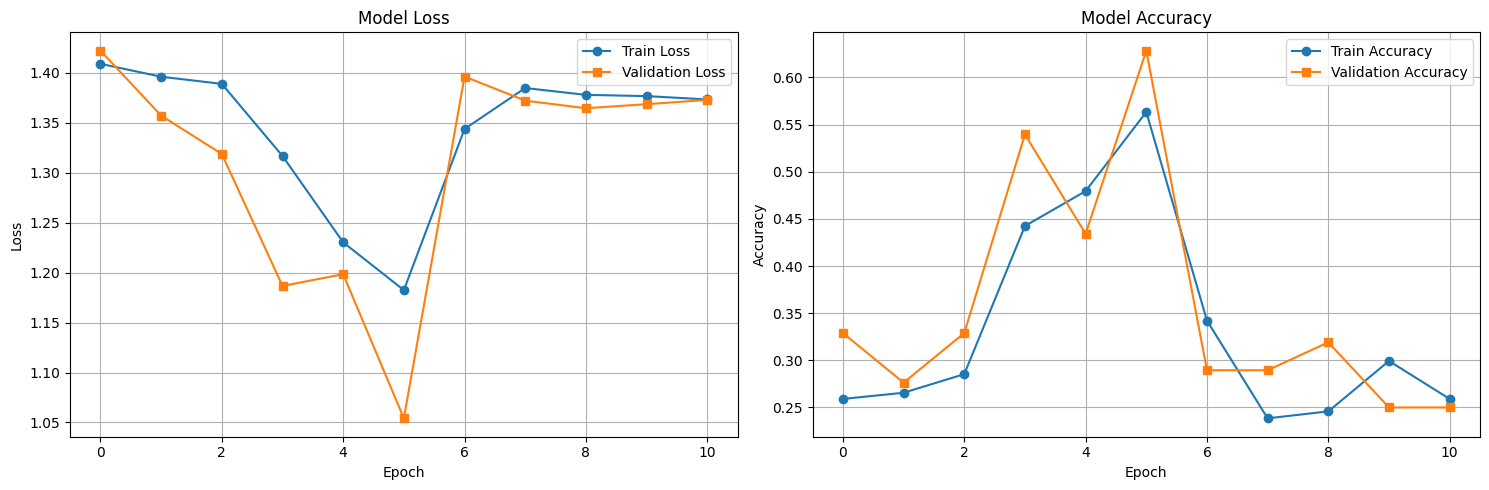

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Test Accuracy: 21.16%
Test Loss: 1.6572

Classification Report:
              precision    recall  f1-score   support

         HGC       0.36      0.14      0.20        74
         LGC       0.18      0.17      0.18        53
         NST       0.22      0.38      0.27        37
         NTL       0.15      0.28      0.19        25

    accuracy                           0.21       189
   macro avg       0.23      0.24      0.21       189
weighted avg       0.25      0.21      0.21       189


Confusion Matrix:
[[10 22 31 11]
 [10  9  7 27]
 [ 8 13 14  2]
 [ 0  5 13  7]]

ROC-AUC Scores:
Macro-average AUC: 0.5616
Micro-average AUC: 0.5097
HGC AUC: 0.6503
LGC AUC: 0.5055
NST AUC: 0.5094
NTL AUC: 0.5810


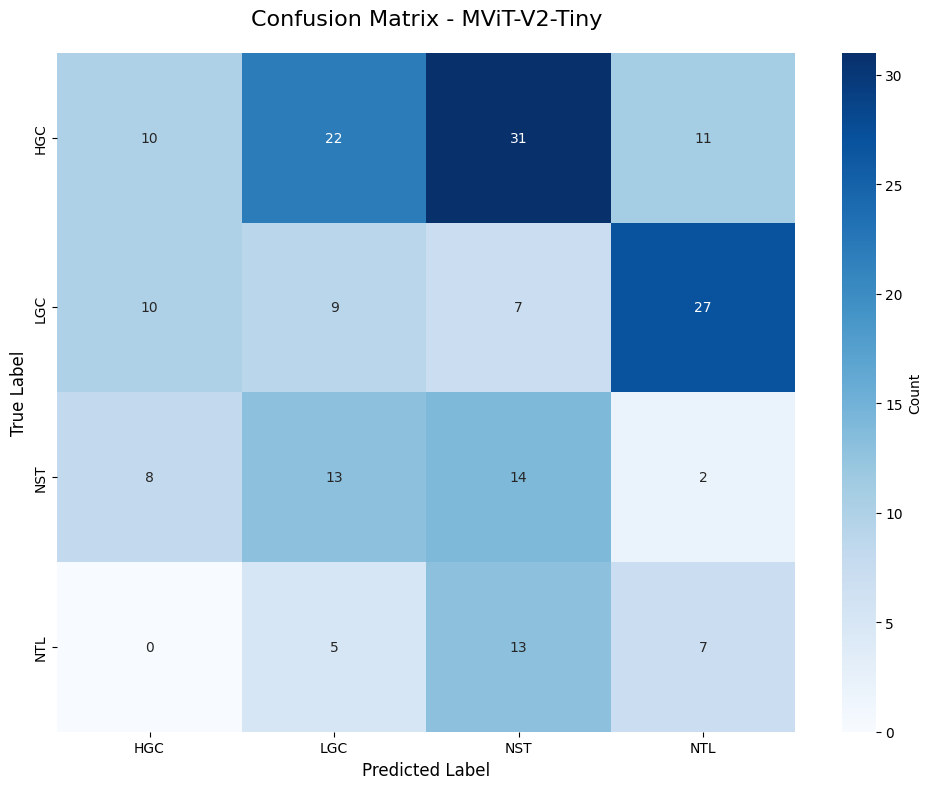

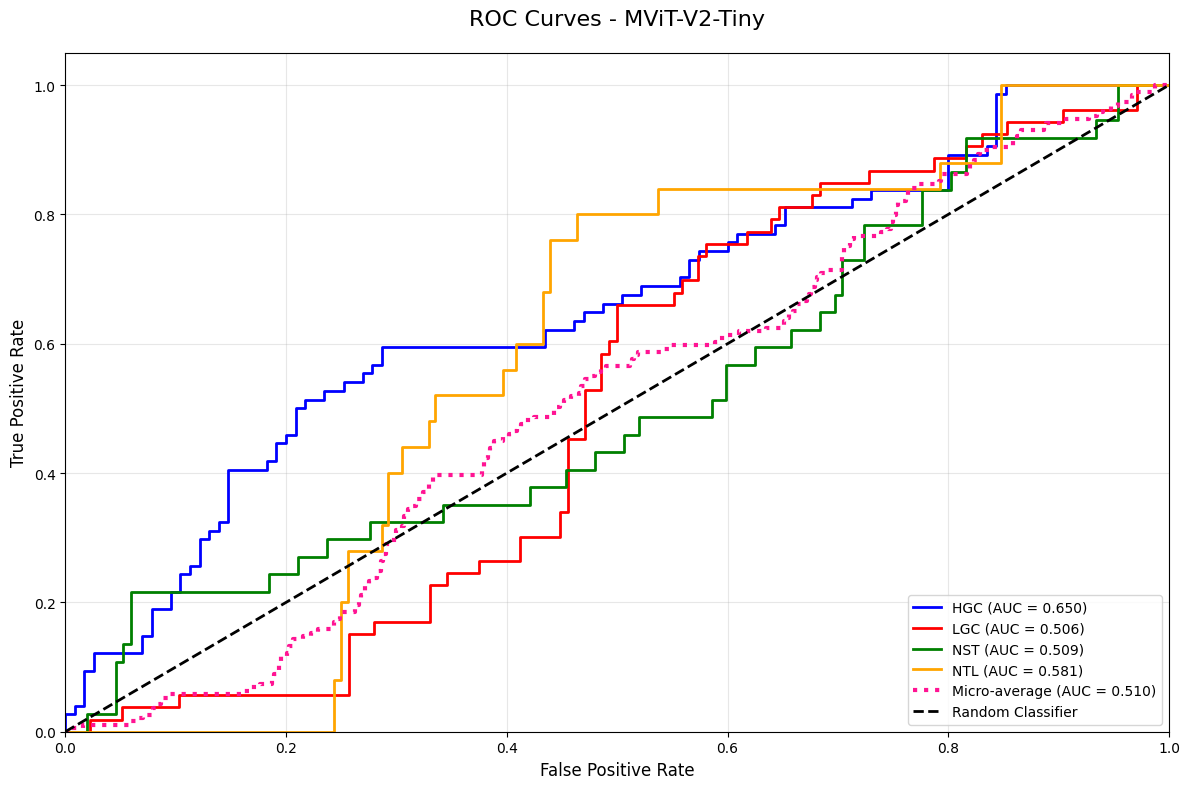


MViT v2 Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training MViT v2 Tiny with Imaging Type")
print("=" * 80)

# Create model
mvit_tiny = create_mvit_model(architecture='mvitv2_tiny', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_mvit_tiny = ModelTrainer(mvit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_tiny = trainer_mvit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Tiny_with_ImagingType")

# Plot training history
trainer_mvit_tiny.plot_training_history(save_path='mvit_v2_tiny_training_history.png')

# Evaluate model
results_mvit_tiny = trainer_mvit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_tiny['confusion_matrix'], class_names, 'MViT-V2-Tiny',
                      save_path='mvit_v2_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_tiny = plot_roc_curves(results_mvit_tiny['labels'], results_mvit_tiny['probabilities'], class_names, 'MViT-V2-Tiny',
                                     save_path='mvit_v2_tiny_roc_curves.png')

# Store results
results_mvit_tiny['model_name'] = 'MViT-V2-Tiny_with_ImagingType'
results_mvit_tiny['roc_auc'] = roc_auc_mvit_tiny
all_results.append(results_mvit_tiny)

print("\nMViT v2 Tiny training and evaluation complete!")

Training MViT v2 Base with Imaging Type


model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.4210, Acc=0.2566]


Train Loss: 1.4210 Acc: 0.2566 Macro-F1: 0.2348


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=1.3769, Acc=0.2500]


Val Loss: 1.3769 Acc: 0.2500 Macro-F1: 0.1560
✓ New best model saved with validation macro-F1: 0.1560

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.3837, Acc=0.2878]


Train Loss: 1.3837 Acc: 0.2878 Macro-F1: 0.2572


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=1.3404, Acc=0.4638]


Val Loss: 1.3404 Acc: 0.4638 Macro-F1: 0.3619
✓ New best model saved with validation macro-F1: 0.3619

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.3240, Acc=0.4655]


Train Loss: 1.3240 Acc: 0.4655 Macro-F1: 0.3938


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=1.2262, Acc=0.4507]


Val Loss: 1.2262 Acc: 0.4507 Macro-F1: 0.3607

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.1869, Acc=0.5567]


Train Loss: 1.1869 Acc: 0.5567 Macro-F1: 0.4661


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=1.0694, Acc=0.6151]


Val Loss: 1.0694 Acc: 0.6151 Macro-F1: 0.5338
✓ New best model saved with validation macro-F1: 0.5338

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.1547, Acc=0.5551]


Train Loss: 1.1547 Acc: 0.5551 Macro-F1: 0.4755


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=1.0894, Acc=0.5526]


Val Loss: 1.0894 Acc: 0.5526 Macro-F1: 0.4470

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.0622, Acc=0.6044]


Train Loss: 1.0622 Acc: 0.6044 Macro-F1: 0.5364


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.9511, Acc=0.6513]


Val Loss: 0.9511 Acc: 0.6513 Macro-F1: 0.5656
✓ New best model saved with validation macro-F1: 0.5656

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.0510, Acc=0.6184]


Train Loss: 1.0510 Acc: 0.6184 Macro-F1: 0.5439


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=1.0179, Acc=0.6118]


Val Loss: 1.0179 Acc: 0.6118 Macro-F1: 0.5501

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.9744, Acc=0.6785]


Train Loss: 0.9744 Acc: 0.6785 Macro-F1: 0.5970


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.9298, Acc=0.6546]


Val Loss: 0.9298 Acc: 0.6546 Macro-F1: 0.5913
✓ New best model saved with validation macro-F1: 0.5913

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.9096, Acc=0.6809]


Train Loss: 0.9096 Acc: 0.6809 Macro-F1: 0.6130


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.8803, Acc=0.6908]


Val Loss: 0.8803 Acc: 0.6908 Macro-F1: 0.6213
✓ New best model saved with validation macro-F1: 0.6213

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.8535, Acc=0.7048]


Train Loss: 0.8535 Acc: 0.7048 Macro-F1: 0.6400


Val : 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, Loss=0.8557, Acc=0.6743]


Val Loss: 0.8557 Acc: 0.6743 Macro-F1: 0.6099

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.8188, Acc=0.7072]


Train Loss: 0.8188 Acc: 0.7072 Macro-F1: 0.6474


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.8181, Acc=0.7072]


Val Loss: 0.8181 Acc: 0.7072 Macro-F1: 0.6427
✓ New best model saved with validation macro-F1: 0.6427

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.7634, Acc=0.7171]


Train Loss: 0.7634 Acc: 0.7171 Macro-F1: 0.6563


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=0.8209, Acc=0.6974]


Val Loss: 0.8209 Acc: 0.6974 Macro-F1: 0.6341

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.7304, Acc=0.7393]


Train Loss: 0.7304 Acc: 0.7393 Macro-F1: 0.6811


Val : 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, Loss=0.7807, Acc=0.7204]


Val Loss: 0.7807 Acc: 0.7204 Macro-F1: 0.6551
✓ New best model saved with validation macro-F1: 0.6551

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.6874, Acc=0.7615]


Train Loss: 0.6874 Acc: 0.7615 Macro-F1: 0.7004


Val : 100%|██████████| 10/10 [00:02<00:00,  3.83it/s, Loss=0.7896, Acc=0.6941]


Val Loss: 0.7896 Acc: 0.6941 Macro-F1: 0.6380

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.6099, Acc=0.7706]


Train Loss: 0.6099 Acc: 0.7706 Macro-F1: 0.7177


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.7533, Acc=0.7336]


Val Loss: 0.7533 Acc: 0.7336 Macro-F1: 0.6708
✓ New best model saved with validation macro-F1: 0.6708

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.5927, Acc=0.7788]


Train Loss: 0.5927 Acc: 0.7788 Macro-F1: 0.7251


Val : 100%|██████████| 10/10 [00:02<00:00,  3.83it/s, Loss=0.7580, Acc=0.7138]


Val Loss: 0.7580 Acc: 0.7138 Macro-F1: 0.6529

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.5845, Acc=0.7812]


Train Loss: 0.5845 Acc: 0.7812 Macro-F1: 0.7300


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.7502, Acc=0.7204]


Val Loss: 0.7502 Acc: 0.7204 Macro-F1: 0.6599

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.5743, Acc=0.7903]


Train Loss: 0.5743 Acc: 0.7903 Macro-F1: 0.7399


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=0.7475, Acc=0.7270]


Val Loss: 0.7475 Acc: 0.7270 Macro-F1: 0.6707

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.5673, Acc=0.7887]


Train Loss: 0.5673 Acc: 0.7887 Macro-F1: 0.7387


Val : 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, Loss=0.7461, Acc=0.7270]


Val Loss: 0.7461 Acc: 0.7270 Macro-F1: 0.6698

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=0.5555, Acc=0.7862]


Train Loss: 0.5555 Acc: 0.7862 Macro-F1: 0.7369


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.7506, Acc=0.7237]


Val Loss: 0.7506 Acc: 0.7237 Macro-F1: 0.6652
Early stopping triggered after 20 epochs
Training complete in 9m 58s
Best validation macro-F1: 0.6708


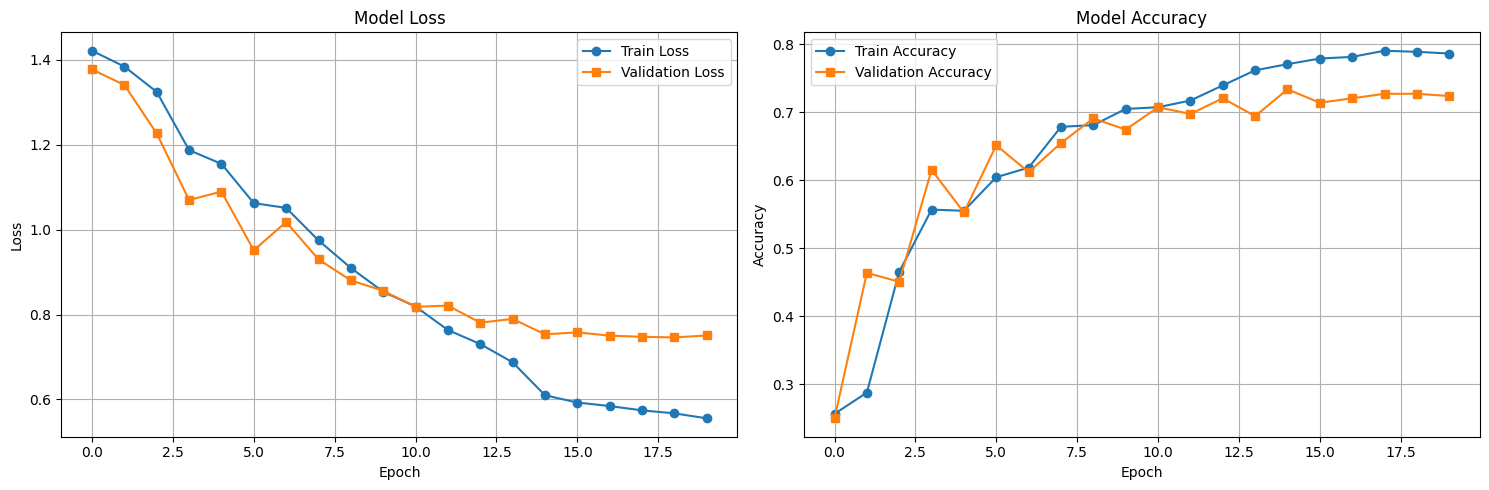

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Test Accuracy: 22.22%
Test Loss: 2.5365

Classification Report:
              precision    recall  f1-score   support

         HGC       0.19      0.16      0.18        74
         LGC       0.03      0.02      0.02        53
         NST       0.38      0.78      0.51        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.22       189
   macro avg       0.15      0.24      0.18       189
weighted avg       0.16      0.22      0.17       189


Confusion Matrix:
[[12 26 34  2]
 [35  1  1 16]
 [ 4  4 29  0]
 [12  0 13  0]]

ROC-AUC Scores:
Macro-average AUC: 0.4792
Micro-average AUC: 0.4806
HGC AUC: 0.2940
LGC AUC: 0.4698
NST AUC: 0.8241
NTL AUC: 0.3290


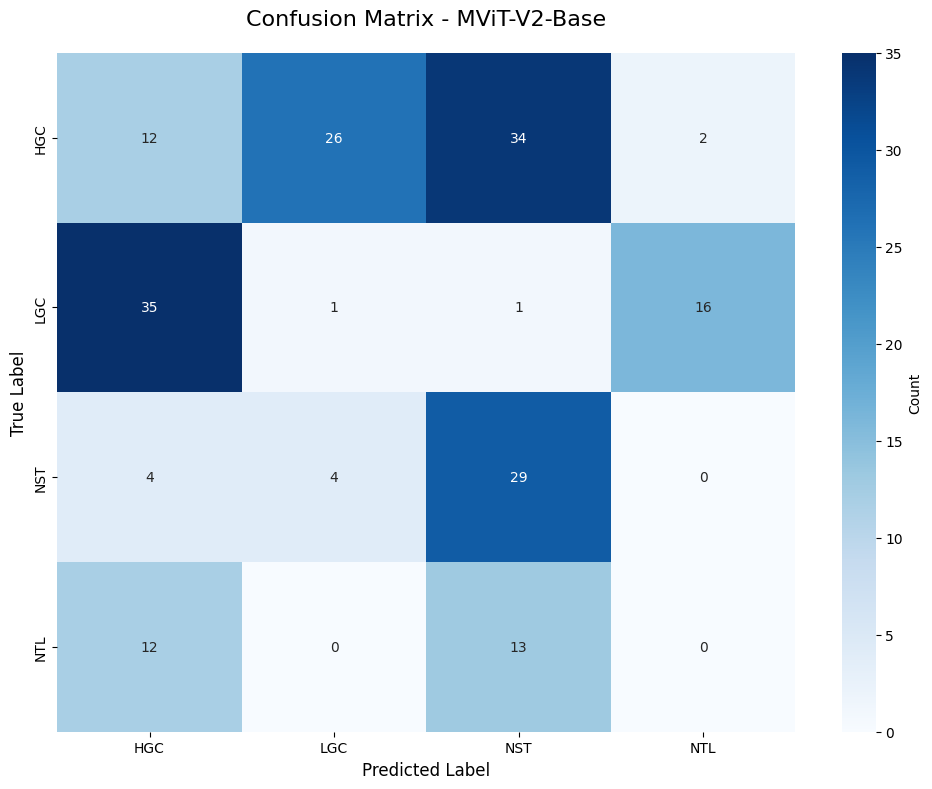

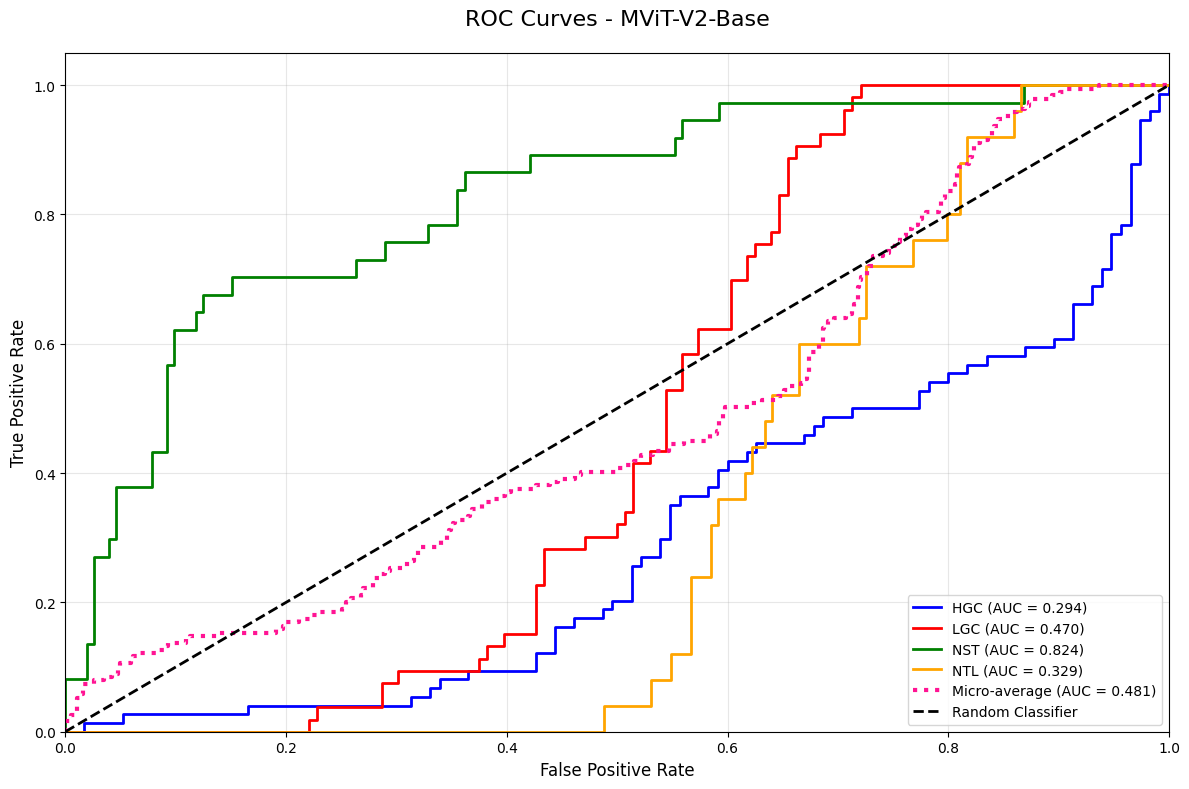


MViT v2 Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training MViT v2 Base with Imaging Type")
print("=" * 80)

# Create model
mvit_base = create_mvit_model(architecture='mvitv2_base', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_mvit_base = ModelTrainer(mvit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_base = trainer_mvit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Base_with_ImagingType")

# Plot training history
trainer_mvit_base.plot_training_history(save_path='mvit_v2_base_training_history.png')

# Evaluate model
results_mvit_base = trainer_mvit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_base['confusion_matrix'], class_names, 'MViT-V2-Base',
                      save_path='mvit_v2_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_base = plot_roc_curves(results_mvit_base['labels'], results_mvit_base['probabilities'], class_names, 'MViT-V2-Base',
                                     save_path='mvit_v2_base_roc_curves.png')

# Store results
results_mvit_base['model_name'] = 'MViT-V2-Base_with_ImagingType'
results_mvit_base['roc_auc'] = roc_auc_mvit_base
all_results.append(results_mvit_base)

print("\nMViT v2 Base training and evaluation complete!")

## Train MViT v2 Base

Training MViT v2 Small with Imaging Type


model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Loss=1.3834, Acc=0.3084]


Train Loss: 1.3834 Acc: 0.3084 Macro-F1: 0.2800


Val : 100%|██████████| 10/10 [00:02<00:00,  4.92it/s, Loss=1.4389, Acc=0.2829]


Val Loss: 1.4389 Acc: 0.2829 Macro-F1: 0.1103
✓ New best model saved with validation macro-F1: 0.1103

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.4019, Acc=0.2697]


Train Loss: 1.4019 Acc: 0.2697 Macro-F1: 0.2481


Val : 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=1.4027, Acc=0.3289]


Val Loss: 1.4027 Acc: 0.3289 Macro-F1: 0.1849
✓ New best model saved with validation macro-F1: 0.1849

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.3677, Acc=0.2475]


Train Loss: 1.3677 Acc: 0.2475 Macro-F1: 0.2401


Val : 100%|██████████| 10/10 [00:02<00:00,  4.98it/s, Loss=1.2257, Acc=0.4375]


Val Loss: 1.2257 Acc: 0.4375 Macro-F1: 0.2596
✓ New best model saved with validation macro-F1: 0.2596

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.2767, Acc=0.4054]


Train Loss: 1.2767 Acc: 0.4054 Macro-F1: 0.3655


Val : 100%|██████████| 10/10 [00:01<00:00,  5.15it/s, Loss=1.1567, Acc=0.4474]


Val Loss: 1.1567 Acc: 0.4474 Macro-F1: 0.3918
✓ New best model saved with validation macro-F1: 0.3918

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1357, Acc=0.4696]


Train Loss: 1.1357 Acc: 0.4696 Macro-F1: 0.4240


Val : 100%|██████████| 10/10 [00:02<00:00,  5.00it/s, Loss=1.1207, Acc=0.4934]


Val Loss: 1.1207 Acc: 0.4934 Macro-F1: 0.4739
✓ New best model saved with validation macro-F1: 0.4739

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.98it/s, Loss=1.1405, Acc=0.5049]


Train Loss: 1.1405 Acc: 0.5049 Macro-F1: 0.4525


Val : 100%|██████████| 10/10 [00:02<00:00,  4.97it/s, Loss=1.1433, Acc=0.4474]


Val Loss: 1.1433 Acc: 0.4474 Macro-F1: 0.3736

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1033, Acc=0.4951]


Train Loss: 1.1033 Acc: 0.4951 Macro-F1: 0.4581


Val : 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=1.0176, Acc=0.4572]


Val Loss: 1.0176 Acc: 0.4572 Macro-F1: 0.4064

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.9336, Acc=0.5814]


Train Loss: 0.9336 Acc: 0.5814 Macro-F1: 0.5493


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=0.8724, Acc=0.6579]


Val Loss: 0.8724 Acc: 0.6579 Macro-F1: 0.6160
✓ New best model saved with validation macro-F1: 0.6160

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.8626, Acc=0.6530]


Train Loss: 0.8626 Acc: 0.6530 Macro-F1: 0.6045


Val : 100%|██████████| 10/10 [00:02<00:00,  4.86it/s, Loss=0.8314, Acc=0.6809]


Val Loss: 0.8314 Acc: 0.6809 Macro-F1: 0.6342
✓ New best model saved with validation macro-F1: 0.6342

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.8083, Acc=0.6702]


Train Loss: 0.8083 Acc: 0.6702 Macro-F1: 0.6256


Val : 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=0.8241, Acc=0.6480]


Val Loss: 0.8241 Acc: 0.6480 Macro-F1: 0.6164

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.7858, Acc=0.6743]


Train Loss: 0.7858 Acc: 0.6743 Macro-F1: 0.6354


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=0.8048, Acc=0.6711]


Val Loss: 0.8048 Acc: 0.6711 Macro-F1: 0.6334

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.7615, Acc=0.6974]


Train Loss: 0.7615 Acc: 0.6974 Macro-F1: 0.6504


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=0.7926, Acc=0.7105]


Val Loss: 0.7926 Acc: 0.7105 Macro-F1: 0.6404
✓ New best model saved with validation macro-F1: 0.6404

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.7311, Acc=0.7146]


Train Loss: 0.7311 Acc: 0.7146 Macro-F1: 0.6664


Val : 100%|██████████| 10/10 [00:01<00:00,  5.00it/s, Loss=0.6954, Acc=0.7270]


Val Loss: 0.6954 Acc: 0.7270 Macro-F1: 0.6858
✓ New best model saved with validation macro-F1: 0.6858

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.6737, Acc=0.7286]


Train Loss: 0.6737 Acc: 0.7286 Macro-F1: 0.6903


Val : 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=0.7055, Acc=0.7204]


Val Loss: 0.7055 Acc: 0.7204 Macro-F1: 0.6675

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.6531, Acc=0.7459]


Train Loss: 0.6531 Acc: 0.7459 Macro-F1: 0.7049


Val : 100%|██████████| 10/10 [00:02<00:00,  5.00it/s, Loss=0.6767, Acc=0.7599]


Val Loss: 0.6767 Acc: 0.7599 Macro-F1: 0.7219
✓ New best model saved with validation macro-F1: 0.7219

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.6383, Acc=0.7442]


Train Loss: 0.6383 Acc: 0.7442 Macro-F1: 0.7017


Val : 100%|██████████| 10/10 [00:02<00:00,  4.92it/s, Loss=0.6636, Acc=0.7500]


Val Loss: 0.6636 Acc: 0.7500 Macro-F1: 0.7043

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.6187, Acc=0.7541]


Train Loss: 0.6187 Acc: 0.7541 Macro-F1: 0.7145


Val : 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=0.6477, Acc=0.7336]


Val Loss: 0.6477 Acc: 0.7336 Macro-F1: 0.6940

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.6101, Acc=0.7549]


Train Loss: 0.6101 Acc: 0.7549 Macro-F1: 0.7164


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=0.6453, Acc=0.7500]


Val Loss: 0.6453 Acc: 0.7500 Macro-F1: 0.7109

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.6070, Acc=0.7566]


Train Loss: 0.6070 Acc: 0.7566 Macro-F1: 0.7173


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=0.6431, Acc=0.7368]


Val Loss: 0.6431 Acc: 0.7368 Macro-F1: 0.6916

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=0.5986, Acc=0.7656]


Train Loss: 0.5986 Acc: 0.7656 Macro-F1: 0.7282


Val : 100%|██████████| 10/10 [00:01<00:00,  5.00it/s, Loss=0.6496, Acc=0.7500]


Val Loss: 0.6496 Acc: 0.7500 Macro-F1: 0.7111
Early stopping triggered after 20 epochs
Training complete in 7m 6s
Best validation macro-F1: 0.7219


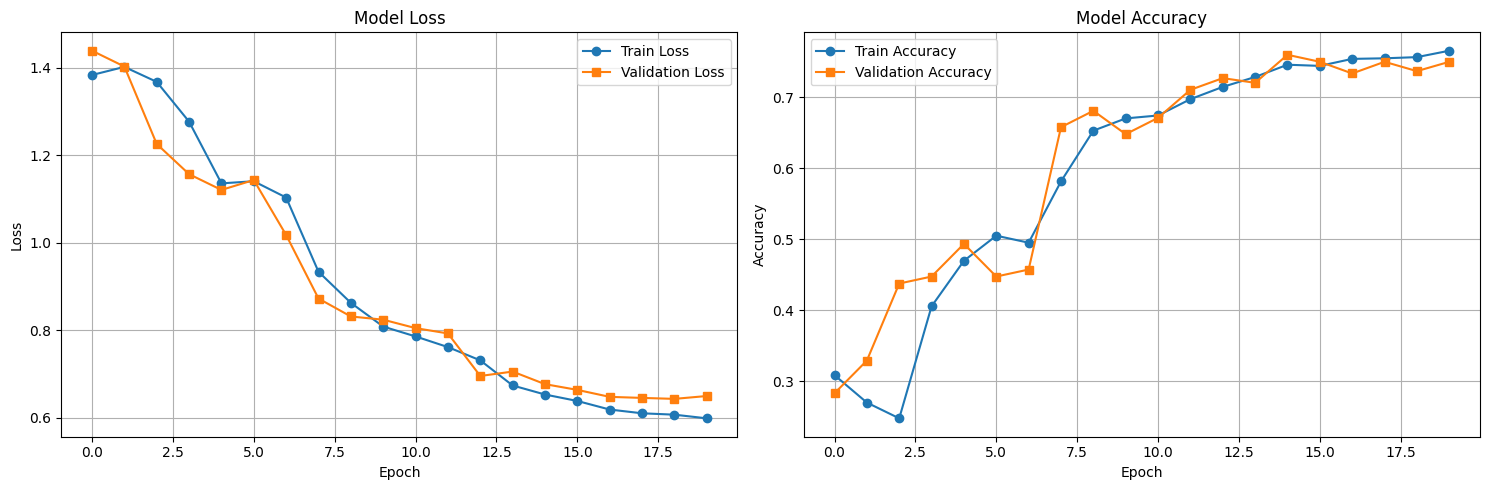

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


Test Accuracy: 52.91%
Test Loss: 1.3334

Classification Report:
              precision    recall  f1-score   support

         HGC       0.74      0.50      0.60        74
         LGC       0.58      0.28      0.38        53
         NST       0.55      0.89      0.68        37
         NTL       0.28      0.60      0.38        25

    accuracy                           0.53       189
   macro avg       0.54      0.57      0.51       189
weighted avg       0.60      0.53      0.52       189


Confusion Matrix:
[[37 11 12 14]
 [13 15  5 20]
 [ 0  0 33  4]
 [ 0  0 10 15]]

ROC-AUC Scores:
Macro-average AUC: 0.7953
Micro-average AUC: 0.7648
HGC AUC: 0.7899
LGC AUC: 0.7549
NST AUC: 0.9251
NTL AUC: 0.7112


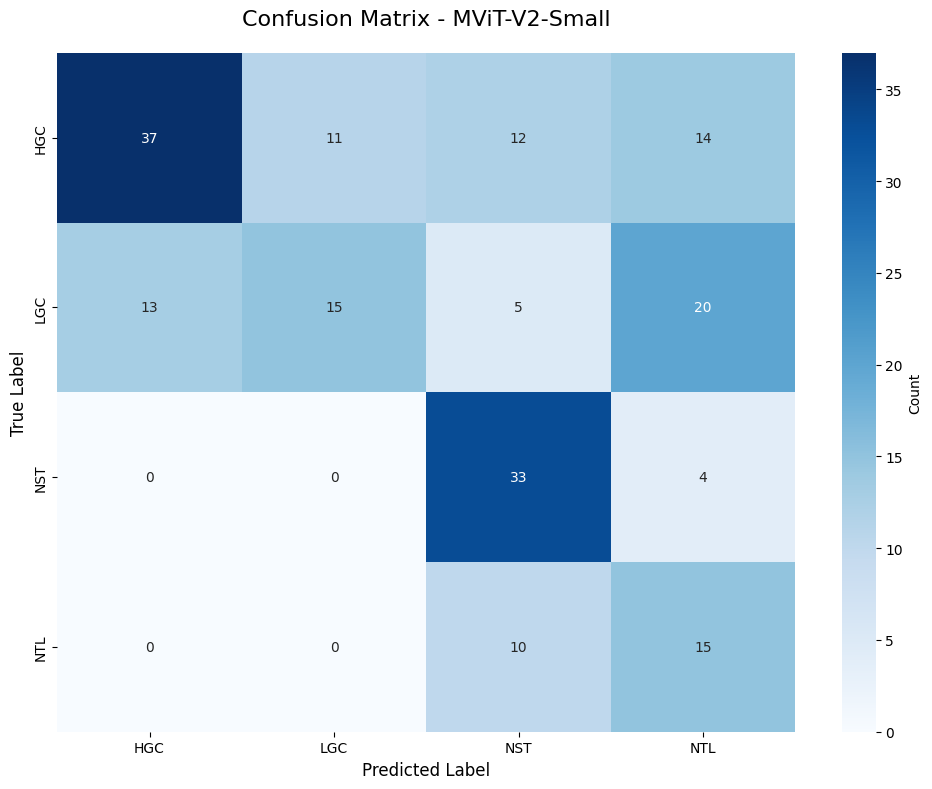

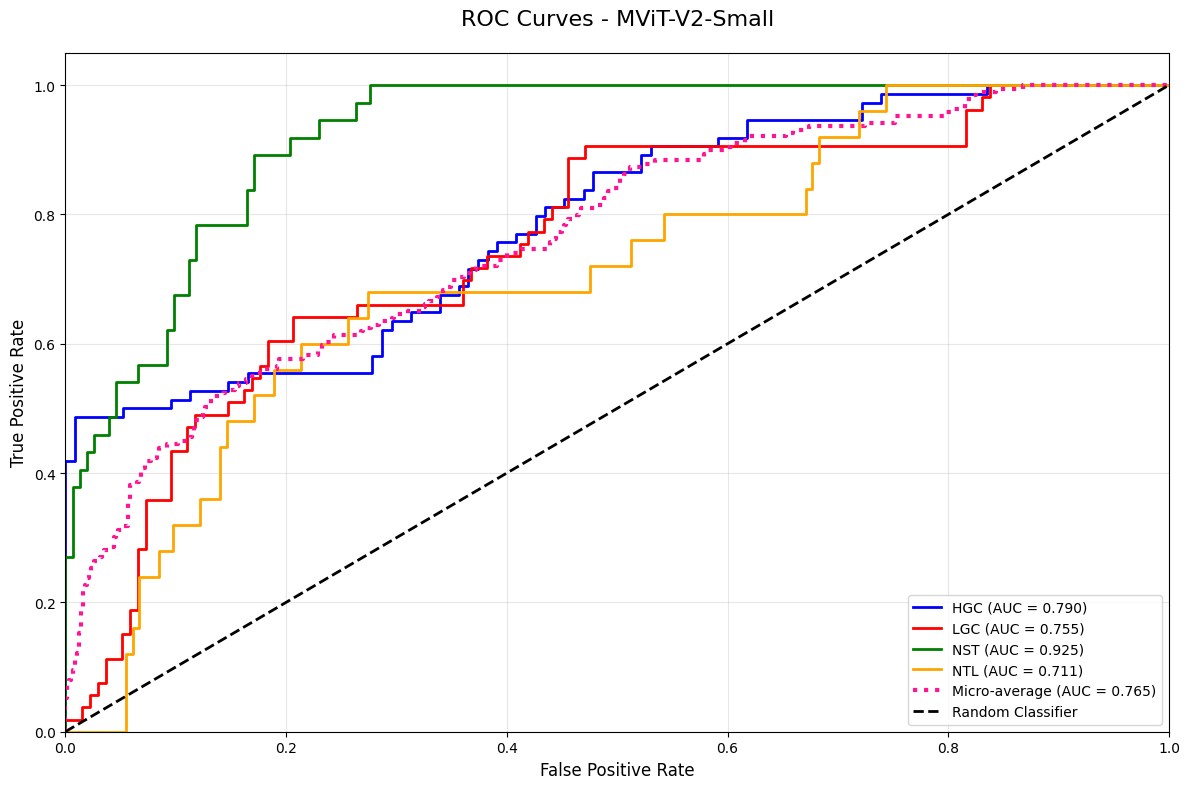


MViT v2 Small training and evaluation complete!


In [18]:
print("=" * 80)
print("Training MViT v2 Small with Imaging Type")
print("=" * 80)

# Create model
mvit_small = create_mvit_model(architecture='mvitv2_small', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_mvit_small = ModelTrainer(mvit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_small = trainer_mvit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Small_with_ImagingType")

# Plot training history
trainer_mvit_small.plot_training_history(save_path='mvit_v2_small_training_history.png')

# Evaluate model
results_mvit_small = trainer_mvit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_small['confusion_matrix'], class_names, 'MViT-V2-Small',
                      save_path='mvit_v2_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_small = plot_roc_curves(results_mvit_small['labels'], results_mvit_small['probabilities'], class_names, 'MViT-V2-Small',
                                     save_path='mvit_v2_small_roc_curves.png')

# Store results
results_mvit_small['model_name'] = 'MViT-V2-Small_with_ImagingType'
results_mvit_small['roc_auc'] = roc_auc_mvit_small
all_results.append(results_mvit_small)

print("\nMViT v2 Small training and evaluation complete!")

## Train MViT v2 Small

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'MViT_V2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: MViT_V2_metrics.csv

Metrics Summary:
                            Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   MViT-V2-Tiny_with_ImagingType         21.164021      1.657186             0.226284          0.240831      0.210376                0.253206             0.211640         0.205718       0.357143    0.135135  0.196078         74.0       0.183673    0.169811  0.176471         53.0       0.215385    0.378378  0.274510         37.0       0.148936        0.28  0.194444         25.0   0.561561   0.509682  0.650294  0.505549  